# Author: Aitor González and Carlos Domínguez

### Install libraries

In [ ]:
!pip3 install tensorflow
# A dependency of the preprocessing for BERT inputs
!pip install -q tensorflow-text
# To use AdamW optimizer from tensorflow/models.
!pip install -q tf-models-official
# For sent analisis and NER
!pip install flair
# For Transformer pretrained weights
!pip install tensorflow_hub

     |████████████████████████████████| 462 kB 28.9 MB/s 


     |████████████████████████████████| 4.9 MB 28.0 MB/s 
     |████████████████████████████████| 2.2 MB 31.7 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 47.7 MB 81 kB/s 
     |████████████████████████████████| 636 kB 53.3 MB/s 
     |████████████████████████████████| 90 kB 10.0 MB/s 
     |████████████████████████████████| 234 kB 75.9 MB/s 
     |████████████████████████████████| 352 kB 78.0 MB/s 
     |████████████████████████████████| 1.2 MB 47.3 MB/s 
     |████████████████████████████████| 1.1 MB 55.7 MB/s 
     |████████████████████████████████| 99 kB 6.9 MB/s 
     |████████████████████████████████| 322 kB 26.6 MB/s 
     |████████████████████████████████| 19.7 MB 1.3 MB/s 
     |████████████████████████████████| 48 kB 6.3 MB/s 
     |████████████████████████████████| 788 kB 53.1 MB/s 
     |████████████████████████████████| 981 kB 16.1 MB/s 
     |████████████████████████████████| 67 kB 5.8 MB/s 
     |██████████████████

### Load libraries

In [ ]:
import pandas as pd

from collections import defaultdict

import numpy as np

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_text as text
from official.nlp import optimization # adamw

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm

from flair.data import Sentence
from flair.models import SequenceTagger
from flair.models import TextClassifier

import matplotlib.pyplot as plt

import string
import re

import json

from tqdm import tqdm

import math

from segtok.segmenter import split_single

### Loading the data and visualizing it

In [ ]:
train_path, dev_path, test_path = "./dataset/Constraint_Train.csv", "./dataset/Constraint_Val.csv", "./dataset/Constraint_Test.csv"

In [ ]:
train_set = pd.read_csv(train_path)
dev_set = pd.read_csv(dev_path)
test_set = pd.read_csv(test_path)

In [ ]:
train_set.tail()

,id,tweet,label
6415,6416,A tiger tested positive for COVID-19 please st...,fake
6416,6417,???Autopsies prove that COVID-19 is??� a blood...,fake
6417,6418,_A post claims a COVID-19 vaccine has already ...,fake
6418,6419,Aamir Khan Donate 250 Cr. In PM Relief Cares Fund,fake
6419,6420,It has been 93 days since the last case of COV...,real


In [ ]:
class news(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, input_files_path):
        self.batch_size = batch_size
        self.dataset = shuffle(pd.read_csv(input_files_path)).reset_index(drop=True)

        self.x = defaultdict(list)
        self.y = defaultdict(int)

        for index, row in self.dataset.iterrows():
            self.x[index] = [row['id'], row['tweet']]
            self.y[index] = 0 if row['label'] == "fake" else 1

        nonEmpty_len = 0
        for i in range(len(self.x)): 
            if self.x[i] != []: 
                nonEmpty_len += 1 # non empty number of values (empty ones are at the end)
        self.data_len = nonEmpty_len

    def __len__(self):
        return math.ceil(self.data_len / self.batch_size)

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        # if idx is higher than num of elements, then return empty list
        # last batch is smaller if  num_elements % batch_size != 0
        i = min(self.data_len, idx * self.batch_size)
        indexes = range(i, min(self.data_len, i + self.batch_size))

        x, y = [], []
        
        for idx in indexes:
            x.append(self.x[idx][1])
            y.append(self.y[idx])

        x, y = np.asarray(x), np.asarray(y, dtype='int32')
        return x, y
    
    def inference_get_item(self, idx):
        x, y, ids = np.asarray(self.x[idx][1]), np.asarray(self.y[idx], dtype='int32'), np.asarray(self.x[idx][0], dtype='int32')
        return x, y, ids

In [ ]:
batch_size = 32
train_ds = news(batch_size, train_path)
dev_ds = news(batch_size, dev_path)
test_ds = news(batch_size, test_path)

In [ ]:
train_ds[0]

(array(['Walmart Amazon Kroger Target and Costco “have not had any reported (coronavirus) cases in the news.”',
        'A viral video purportedly from Italy shows a child crying for his mother who died due to coronavirus.',
        'People in USA march and call for the arrest of Bill Gates.',
        'Nebraska is still 1 of only 3 states not releasing any race or ethnicity information. The others are North Dakota (@ndgov &amp; @DougBurgum) and Nevada (@NVGovernment &amp; @GovSisolak)',
        "📢#CoronaVirusUpdates: ✅India's #COVID19 recovery rate improves to 76.63% as on August 31 2020 📍Steady improvement in India's COVID-19 recovery rate since #lockdown initiation on March 25 2020 #IndiaFightsCorona @ICMRDELHI Via @MoHFW_INDIA https://t.co/tzWv6qt3Jv",
        'A tweet by Pakistani journalist Saadia Afzaal claiming that China has developed a COVID-19 vaccine.',
        'Feb. 14: “We have a very small number of people in the country right now with it. It’s like around 12. Many of the

In [ ]:
train_ds.inference_get_item(0)

(array('Walmart Amazon Kroger Target and Costco “have not had any reported (coronavirus) cases in the news.”',
       dtype='<U100'), array(0, dtype=int32), array(1755, dtype=int32))

### Network definition

In [ ]:
def build_TFclassifier_model(preprocessing_layer, encoder):
    
    #inputs
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

    #document
    encoder_inputs = preprocessing_layer(text_input)
    enc_out = encoder(encoder_inputs)
    doc_v = enc_out['pooled_output']

    #dense
    out = tf.keras.layers.Dense(2, activation="softmax", name="Classifier")(doc_v)

    return tf.keras.Model(inputs=[text_input], outputs=[out])

### Training the transformer

In [ ]:
epochs = 3
init_lr = 3e-5
patience = 5

In [ ]:
#'small_bert/bert_en_uncased_L-4_H-512_A-8'
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

#layers
preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')

In [ ]:
!nvidia-smi

Fri Mar  4 12:11:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    58W / 149W |    663MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Free up RAM in case the model definition cells were run multiple times
clear_session()

classifier_model = build_TFclassifier_model(preprocessing_layer, encoder)
classifier_model.summary()

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metrics = tf.metrics.SparseCategoricalAccuracy()

steps_per_epoch = len(train_ds)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

# callback for early stop
earlystopper = EarlyStopping(patience=patience, verbose=1, restore_best_weights=True)

callbacks = [earlystopper] 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=dev_ds,
                               epochs=epochs,
                               callbacks=callbacks)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/3
201/201 [==============================] - 402s 2s/step - loss: 0.2440 - sparse_categorical_accuracy: 0.8905 - val_loss: 0.1046 - val_sparse_categorical_accuracy: 0.9593
Epoch 2/3
201/201 [==============================] - 382s 2s/step - loss: 0.0636 - sparse_categorical_accuracy: 0.9801 - val_loss: 0.0861 - val_sparse_categorical_accuracy: 0.9701
Epoch 3/3
201/201 [==============================] - 381s 2s/step - loss: 0.0214 - sparse_categorical_accuracy: 0.9945 - val_loss: 0.1178 - val_sparse_categorical_accuracy: 0.9710


In [ ]:
classifier_model.save_weights( './output/ft_bert_fakeNews.h5' )

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


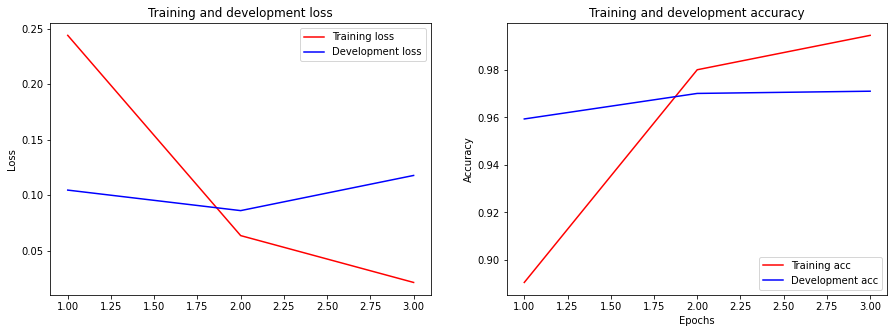

In [ ]:
# Plot train_val loss - metric
history_dict = history.history
print(history_dict.keys())

acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(15, 5))
fig.tight_layout()

plt.subplot(1, 2, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Development loss')
plt.title('Training and development loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Development acc')
plt.title('Training and development accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

### Obtaining other features

In [ ]:
# Sentiment analysis
polarity_classifier = TextClassifier.load('en-sentiment')
# NER tagger
ner_tagger = SequenceTagger.load('ner-fast')
# POS tagger
pos_tagger = SequenceTagger.load('pos-fast')
# The number of sentences: Check the number of sentences that the text has.
# Sentences length: Check the length of the sentences. Maybe short sentences are used to make the topic vaguer.
# Punctuation: number of spaces, paragraphs, hashtags, and so on
# Sources: Check whether the message sends you to another source using URLs.
# Char/Word count


2022-03-04 12:30:36,995 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmp3qhzs8cu


100%|██████████| 265512723/265512723 [00:06<00:00, 38124716.43B/s]

2022-03-04 12:30:44,054 copying /tmp/tmp3qhzs8cu to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2022-03-04 12:30:44,692 removing temp file /tmp/tmp3qhzs8cu
2022-03-04 12:30:44,733 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

2022-03-04 12:31:00,778 --------------------------------------------------------------------------------
2022-03-04 12:31:00,779 The model key 'ner-fast' now maps to 'https://huggingface.co/flair/ner-english-fast' on the HuggingFace ModelHub
2022-03-04 12:31:00,780  - The most current version of the model is automatically downloaded from there.
2022-03-04 12:31:00,785  - (you can alternatively manually download the original model at https://nlp.informatik.hu-berlin.de/resources/models/ner-fast/en-ner-fast-conll03-v0.4.pt)
2022-03-04 12:31:00,787 --------------------------------------------------------------------------------


Downloading:   0%|          | 0.00/257M [00:00<?, ?B/s]

2022-03-04 12:31:16,797 loading file /root/.flair/models/ner-english-fast/4c58e7191ff952c030b82db25b3694b58800b0e722ff15427f527e1631ed6142.e13c7c4664ffe2bbfa8f1f5375bd0dced866b8c1dd7ff89a6d705518abf0a611
2022-03-04 12:31:19,145 --------------------------------------------------------------------------------
2022-03-04 12:31:19,146 The model key 'pos-fast' now maps to 'https://huggingface.co/flair/pos-english-fast' on the HuggingFace ModelHub
2022-03-04 12:31:19,153  - The most current version of the model is automatically downloaded from there.
2022-03-04 12:31:19,155  - (you can alternatively manually download the original model at https://nlp.informatik.hu-berlin.de/resources/models/pos-fast/en-pos-ontonotes-fast-v0.5.pt)
2022-03-04 12:31:19,157 --------------------------------------------------------------------------------


Downloading:   0%|          | 0.00/75.3M [00:00<?, ?B/s]

2022-03-04 12:31:23,058 loading file /root/.flair/models/pos-english-fast/36f7923039eed4c66e4275927daaff6cd275997d61d238355fb1fe0338fe10a1.ff87e5b4e47fdb42a0c00237d9506c671db773e0a7932179ace82e584383a1b8


In [ ]:
punctuation_symbols = set(string.punctuation)

In [ ]:
def obtain_features(text):
    features = {"text":text}

    # URLS
    regex = "((https?):((//)|(\\\\))+[\w\d:#@%/;$()~_?\+-=\\\.&]*)"
    urls = re.findall(regex, text)
    features['urls'] = len(urls)
    for lst in urls:
        biggest, index = 0, 0
        for i, url in enumerate(lst):
            if len(url) > biggest:
                biggest = len(url)
                index = i
                
        text = text.replace(lst[index], "")
    
    text_tokenized = Sentence(text, use_tokenizer=True)
    sents = [Sentence(s, use_tokenizer=True) for s in split_single(text)] # divide text in sentences
    
    # Sentiment analysis
    polarity_classifier.predict(text_tokenized)
    output =  text_tokenized.labels[0].to_dict()
    features["polarity"] = [output['value'], output['confidence']]

    # NER and POS tager
    ner_tags, pos_tags = defaultdict(int), defaultdict(int)
    ner_tagger.predict(sents)
    pos_tagger.predict(sents)
    for tokenized_sent in sents:
        for span in tokenized_sent.get_spans("ner"):
            ner_tags[span.tag] += 1

        for span in tokenized_sent.get_spans("pos"):
            # Sometimes in POS appears punctuation symbols
            if span.tag in punctuation_symbols:
                continue
            pos_tags[span.tag] += 1

    features["ner"] = ner_tags
    features["pos"] = pos_tags

    # The number of sentences: Check the number of sentences that the text has.
    features['num_sent']= len(sents)

    # punctuation
    punctuation = defaultdict(int)
    for char in text:
        if char in punctuation_symbols:
            punctuation[char] += 1
    features["punctuation"] = punctuation

    total_words = []
    for token in text_tokenized:
        if token.text in punctuation_symbols:
            continue
        total_words.append(len(token.text))
    
    features["mean_char_per_word"] = np.mean(total_words)
    features["std_char_per_word"] = np.std(total_words)
    
    total_words_per_sentence = []
    for s in sents:
        total_words_per_sentence.append(0)
        for token in s:
            if token.text in punctuation_symbols:
                continue
            total_words_per_sentence[-1] += 1
    
    features["mean_word_per_sent"] = np.mean(total_words_per_sentence)
    features["std_word_per_sent"] = np.std(total_words_per_sentence)

    return features

In [ ]:
def parse_dataset(file_path, name):
    output_file = {}
    df = pd.read_csv(file_path)
    for index, row in tqdm(df.iterrows()):
        output_file[row['id']] = obtain_features(row["tweet"])
    
    with open(name, "w") as f:
        json.dump(output_file, f)
    return output_file

In [ ]:
print("Start train")
output_train = parse_dataset(train_path, "./output/train.json")
print("Finished train")
print("Start dev")
output_dev = parse_dataset(dev_path, "./output/dev.json")
print("Finished dev")
print("Start test")
output_test = parse_dataset(test_path, "./output/test.json")
print("Finished test")

In [ ]:
def eval_and_get_pred(dataset, name, batch_size_value, save_file):
    # Now, we calculate the final test metrics
    preds_test = classifier_model.predict(dataset, batch_size=batch_size_value)

    with open(save_file, "r") as f:
        json_file = json.load(f)

    gt_y, pred_y = [], []
    for i in range(len(preds_test)):
        x, y, idx = dataset.inference_get_item(i)
        gt_y.append(y)
        pred_y.append(0 if preds_test[i][0] >= preds_test[i][1] else 1)
        
        json_file[str(idx)]['transformer'] = float(0 if preds_test[i][0] >= preds_test[i][1] else 1)
        json_file[str(idx)]['transformer_confidence'] = float(preds_test[i][0] if preds_test[i][0] >= preds_test[i][1] else preds_test[i][1])
        json_file[str(idx)]['ground_truth'] = float(y) 

    
    with open(save_file, "w") as f:
        json.dump(json_file, f, indent = 4, sort_keys=False)

    print("{} precision:".format(name), precision_score(gt_y, pred_y))
    print("{} accuracy:".format(name), accuracy_score(gt_y, pred_y))
    print("{} recall:".format(name), recall_score(gt_y, pred_y))
    print("{} f1-score:".format(name), f1_score(gt_y, pred_y))

In [ ]:
classifier_model.load_weights("./output/ft_bert_fakeNews.h5")

In [ ]:
eval_and_get_pred(train_ds, "train", 32, "./output/train.json")
eval_and_get_pred(dev_ds, "dev", 32, "./output/dev.json")
eval_and_get_pred(test_ds, "test", 32, "./output/test.json")

train precision: 0.9958456973293769
train accuracy: 0.997196261682243
train recall: 0.9988095238095238
train f1-score: 0.9973254086181278
dev precision: 0.9592013888888888
dev accuracy: 0.9710280373831776
dev recall: 0.9866071428571429
dev f1-score: 0.9727112676056339
test precision: 0.96512641673932
test accuracy: 0.9752336448598131
test recall: 0.9883928571428572
test f1-score: 0.976621085134539


#### Create the features matrix

In [ ]:
def total_features(file_name):
    # idx + urls + polarity + num_set + mean_char_per_word + std_char_per_word + mean_word_per_sent + std_word_per_sent+ transformer + ground truth
    size = 1 + 1 + 2 + 1 + 1 + 1 + 1 + 1 + 2 + 1
    pos, ner, punctuation = set(), set(), set()
    names_features = set(["idx", "urls", "polarity", "polarity_condifence", "num_set", "mean_char_per_word", "std_char_per_word", "mean_word_per_sent", "std_word_per_sent", "transformer", "transformer_confidence", "ground_truth"])
    with open(file_name, "r") as f:
        json_file = json.load(f)

    for key, item in json_file.items():
        pos = pos.union(set(item["pos"].keys()))
        ner = ner.union(set(item["ner"].keys()))
        punctuation = punctuation.union(set(item["punctuation"].keys()))

    size = size + len(pos) + len(ner) + len(punctuation)
    print(size) # number of columns
    print(names_features)
    print(['pos_'+i for i in pos])
    print(['ner_'+i for i in ner])
    print(['punctuation_'+i for i in punctuation])
    

size = total_features("./output/train.json")

87
{'ground_truth', 'num_set', 'polarity', 'urls', 'mean_char_per_word', 'transformer_confidence', 'idx', 'mean_word_per_sent', 'std_word_per_sent', 'transformer', 'polarity_condifence', 'std_char_per_word'}
['pos_WDT', 'pos_VBZ', 'pos_PRP$', 'pos_ADD', 'pos_XX', 'pos_RBR', 'pos_WP$', 'pos_TO', 'pos_PDT', 'pos_NFP', 'pos_CC', 'pos_-RRB-', 'pos_-LRB-', 'pos_VB', 'pos_HYPH', 'pos_RBS', 'pos_NNP', 'pos_PRP', 'pos_VBD', 'pos_FW', 'pos_JJS', 'pos_SYM', 'pos_IN', 'pos_VBN', 'pos_CD', "pos_''", 'pos_RP', 'pos_``', 'pos_NNS', 'pos_EX', 'pos_RB', 'pos_NNPS', 'pos_JJR', 'pos_LS', 'pos_VBG', 'pos_JJ', 'pos_DT', 'pos_WRB', 'pos_AFX', 'pos_MD', 'pos_POS', 'pos_NN', 'pos_WP', 'pos_UH', 'pos_VBP']
['ner_LOC', 'ner_MISC', 'ner_ORG', 'ner_PER']
['punctuation_$', 'punctuation_#', 'punctuation_~', 'punctuation_]', 'punctuation_%', 'punctuation_&', 'punctuation_!', 'punctuation_<', 'punctuation_,', 'punctuation_/', 'punctuation_|', 'punctuation_-', 'punctuation_=', 'punctuation_)', 'punctuation_@', 'punct

In [ ]:
# json to pandas df, and save matrix as csv
def create_matrix(file_name, out_file_name):

    pos_names = ['pos_JJ', 'pos_VBG', 'pos_NNS', 'pos_NNP', 'pos_UH', 'pos_JJR', 'pos_VBN', 'pos_PRP$', 'pos_PDT', 'pos_NN', 'pos_JJS', 'pos_LS', 'pos_IN', 'pos_NFP', 'pos_ADD', 'pos_EX', 'pos_DT', 'pos_WDT', 'pos_POS', 'pos_WP$', 'pos_PRP', 'pos_TO', 'pos_WRB', 'pos_``', 'pos_RB', 'pos_RBR', 'pos_FW', 'pos_CD', "pos_''", 'pos_MD', 'pos_-RRB-', 'pos_-LRB-', 'pos_VBZ', 'pos_SYM', 'pos_VBP', 'pos_XX', 'pos_RP', 'pos_AFX', 'pos_NNPS', 'pos_WP', 'pos_VB', 'pos_VBD', 'pos_RBS', 'pos_CC', 'pos_HYPH',]
    ner_names = ['ner_MISC', 'ner_LOC', 'ner_PER', 'ner_ORG',]
    punctuation_names = ['punctuation_)', 'punctuation_"', 'punctuation_-', 'punctuation_!', 'punctuation_[', 'punctuation_<', 'punctuation_+', 'punctuation_|', "punctuation_'", 'punctuation__', 'punctuation_/', 'punctuation_=', 'punctuation_(', 'punctuation_;', 'punctuation_.', 'punctuation_,', 'punctuation_#', 'punctuation_$', 'punctuation_%', 'punctuation_:', 'punctuation_&', 'punctuation_]', 'punctuation_~', 'punctuation_@', 'punctuation_?', 'punctuation_*',]
    
    df = pd.DataFrame(columns = [
        "idx", "urls", "polarity", "polarity_condifence", "num_set", "mean_char_per_word", "std_char_per_word", "mean_word_per_sent", 
        "std_word_per_sent", "transformer", "transformer_confidence", "ground_truth"]
        + pos_names + ner_names + punctuation_names)
    
    with open(file_name, "r") as f:
        json_file = json.load(f)

    for key, item in json_file.items():
        new_row = {"idx":int(key), "urls":item['urls'], "polarity":1 if item["polarity"][0] == "POSITIVE" else 0, 
        "polarity_condifence": item["polarity"][1], "num_set":item['num_sent'], "mean_char_per_word":item['mean_char_per_word'], 
        "std_char_per_word":item['std_char_per_word'], "mean_word_per_sent":item['mean_word_per_sent'], "std_word_per_sent":item['std_word_per_sent'],
        "transformer":item["transformer"], "transformer_confidence":item['transformer_confidence'], "ground_truth":item['ground_truth']
        }
        

        for name in pos_names + ner_names + punctuation_names:
            new_row[name] = 0

        for pos_key, pos_v in item["pos"].items():
            new_row['pos_' + pos_key] = pos_v
        for ner_key, ner_v in item['ner'].items():
            new_row['ner_' + ner_key] = ner_v 
        for punctuation_key, punctuation_v in item["punctuation"].items():
            new_row['punctuation_' + punctuation_key] = punctuation_v

        df = df.append(new_row, ignore_index=True)
        
    df.to_csv("./output/feature_class_{}.csv".format(out_file_name))
    return df

In [ ]:
df_train = create_matrix("./output/train.json", "train")
df_dev = create_matrix("./output/dev.json", "dev")
df_test = create_matrix("./output/test.json", "test")

### Train and show results

In [ ]:
def train_test_models_r_times(r, X_train, y_train, X_test, y_test):
    resul = {
        'NB': {'acc': [],'prec': [],'rec': [],'f-score': []},
        'MLP':{'acc': [],'prec': [],'rec': [],'f-score': []},
        'RF':{'acc': [],'prec': [],'rec': [],'f-score': []},
        'DT':{'acc': [],'prec': [],'rec': [],'f-score': []},
        }
    for seed in range(r): # repetitions
        # we use seed to be able to reproduce the results
        NB_y_pred = GaussianNB().fit(X_train, y_train).predict(X_test)
        MLP_y_pred = MLPClassifier(random_state=seed, early_stopping=True, max_iter=1000).fit(X_train, y_train).predict(X_test)
        RF_y_pred = RandomForestClassifier(random_state=seed).fit(X_train, y_train).predict(X_test)
        DT_y_pred = DecisionTreeClassifier().fit(X_train, y_train).predict(X_test)

        for key, pred in {'NB':NB_y_pred, 'MLP':MLP_y_pred, 'RF':RF_y_pred, 'DT':DT_y_pred}.items():
            resul[key]['acc'].append(accuracy_score(y_test, pred))
            resul[key]['prec'].append(precision_score(y_test, pred))
            resul[key]['rec'].append(recall_score(y_test, pred))
            resul[key]['f-score'].append(f1_score(y_test, pred))
    return resul

def print_resul(resul):
    metricas = ['acc', 'prec', 'rec', 'f_score']

    [print('{:^15}'.format(key), end='') for key in ['']+metricas]
    print('')

    for k,scores in resul.items(): # para cada clasificador
        mu = np.mean(list(scores.values()), axis=1)
        std = np.std(list(scores.values()), axis=1)
        print('{:<15}'.format(" "*6 + k), end='')
        for j, key in enumerate(metricas):
            print("{:^15}".format( "{:.4f} ±{:.4f}".format( mu[j], std[j])), end='')
        print('')


### Final results

### Training classifiers: transformer and features

In [ ]:
X_train = df_train.loc[:, df_train.columns != 'ground_truth'].to_numpy()
y_train = df_train.loc[:, 'ground_truth'].to_numpy()
X_test = df_test.loc[:, df_test.columns != 'ground_truth'].to_numpy()
y_test = df_test.loc[:, 'ground_truth'].to_numpy()

In [ ]:
resul = train_test_models_r_times(20, X_train, y_train, X_test, y_test)
print_resul(resul)

                     acc           prec            rec          f_score    
      NB       0.9724 ±0.0000 0.9674 ±0.0000 0.9804 ±0.0000 0.9738 ±0.0000 
      MLP      0.9675 ±0.0060 0.9552 ±0.0079 0.9840 ±0.0035 0.9694 ±0.0056 
      RF       0.9780 ±0.0007 0.9702 ±0.0013 0.9882 ±0.0004 0.9791 ±0.0007 
      DT       0.9793 ±0.0007 0.9804 ±0.0009 0.9800 ±0.0020 0.9802 ±0.0007 


### Training classifiers: Only features

In [ ]:
X_train = df_train.loc[:, ~df_train.columns.isin(['ground_truth', 'transformer', 'transformer_confidence'])].to_numpy()
y_train = df_train.loc[:, 'ground_truth'].to_numpy()
X_test = df_test.loc[:, ~df_test.columns.isin(['ground_truth', 'transformer', 'transformer_confidence'])].to_numpy()
y_test = df_test.loc[:, 'ground_truth'].to_numpy()

In [ ]:
resul = train_test_models_r_times(20, X_train, y_train, X_test, y_test)
print_resul(resul)

                     acc           prec            rec          f_score    
      NB       0.8023 ±0.0000 0.8218 ±0.0000 0.7946 ±0.0000 0.8080 ±0.0000 
      MLP      0.8726 ±0.0092 0.8596 ±0.0138 0.9046 ±0.0082 0.8814 ±0.0076 
      RF       0.9275 ±0.0017 0.9122 ±0.0023 0.9531 ±0.0029 0.9322 ±0.0016 
      DT       0.8668 ±0.0029 0.8675 ±0.0027 0.8800 ±0.0054 0.8737 ±0.0030 


Only transformer:

test accuracy: 0.9752336448598131

test precision: 0.96512641673932

test recall: 0.9883928571428572

test f1-score: 0.976621085134539
